In [7]:
from systemclass import SNAIL,SNAILC,SNAIL_sweep,SNAILC_sweep,Cavity
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

In [8]:
flux_values = np.linspace(0.4312, 0.4316, 30)

In [9]:
EJ = 100*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 100
flux = 0.4325
N = 3
dims = 8

# truncated_dim:int = 6
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

omega_c1 = 8.5*2*np.pi
g_int1 =  0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
dimc1 = 5
trunc1 = dims * dimc1
cavity1 = Cavity(omega_c1,g_int1,dimc1)


Hss = []
charge_ops = []
snail_freqs = []
snail_freqs2 = []
for flux in flux_values:
    snail_back = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    snail_freqs.append(snail_back.omegas)
    H, op = snail_back.spectrum_charge()
    snail_freqs2.append(H[2,2]/2/np.pi)
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , charge_op = snailc.dressed_H, snailc.dressed_charge
    Hss.append(Hs)
    charge_ops.append(charge_op)

In [10]:
def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return np.abs(1/(factor*10**-6*der))
def find_best_b_and_k(a, B, omega):
    min_diff = float('inf')  # Initialize with a very large number
    best_b = None
    best_k = None

    # Iterate over each element in B
    for b in B:
        # Iterate over each k in the range [-1000, 1000]
        for k in range(-1000, 1001):  # 1001 is used to include 1000 in the range
            diff = abs(a - (b + k * omega))
            # Update min_diff and best_b if a smaller difference is found
            if diff < min_diff:
                min_diff = diff
                best_b = b
                best_k = k

    return best_b, best_k, min_diff

In [11]:
import qutip as qt  
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
# Function to calculate overlap (you might use inner product, fidelity, etc.)
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def floquet_spec(flux, omega, A,A1):
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 100
    N = 3
    dims = 8

    # truncated_dim:int = 6
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

    omega_c1 = 8.5*2*np.pi
    g_int1 =  0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 5
    trunc1 = dims * dimc1
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    snail_back = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    H, op = snail_back.spectrum_charge()
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , Hc = snailc.dressed_H, snailc.dressed_charge
    energy = np.diag(Hs)
    omegas = snail_back.omegas
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexc1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc2 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexsc = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexs2 = np.argmin(np.abs(energy - (2*omegas) * np.ones(len(energy))))
    Hs = Qobj(Hs)
    
    Hc = Qobj(Hc)
    omega1 = 1.2*2*np.pi
    args = {'w': omega,'ww':omega1}
    T = 2*np.pi/omega1
    H = [Hs,  [Hc, lambda t, args: A1*np.cos(args['ww']*t)]]
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [qt.basis(trunc1, 0),qt.basis(trunc1,indexc1)]
    max_overlap_indices = [0,0]
    max_overlaps = [0,0]
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
            
            
            
    ground_state = f_modes[max_overlap_indices[0]]
    cavity_state = f_modes[max_overlap_indices[1]]

    T = 10
    H = [Hs,  [Hc, lambda t, args: A*np.cos(args['w']*t)],[Hc, lambda t, args: A1*np.cos(args['ww']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [ground_state,qt.basis(trunc1, indexs1),cavity_state,qt.basis(trunc1,indexc2),qt.basis(trunc1,indexsc)
                   ,qt.basis(trunc1,indexsc),qt.basis(trunc1,indexs2)]
    
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    omega = 2*np.pi/T
    max_overlap_indices = [-1] * 7
    max_overlaps = [0] * 7
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    energys1 = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    
    energyc1 = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1, omega/2/np.pi)
    energyc1 = energyc1 + k*omega/2/np.pi - energyg
    
    energysc = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc, omega/2/np.pi)
    starkshift = energysc - energyg + k*omega/2/np.pi - energyc1 - energys1
    
    energyc2 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc2, omega/2/np.pi)
    energyc2 = energyc2 +k*omega/2/np.pi
    
    selfkerr = energyc2-energyg - 2*energyc1
    
    energys2 = f_energies[max_overlap_indices[5]]/2/np.pi
    
    k = find_optimal_k(2*omegas/2/np.pi, energys2, omega/2/np.pi)
    energys2 = energys2 + k*omega/2/np.pi - energyg
#     print(f_energies[max_overlap_indices[1]],f_energies[max_overlap_indices[0]])
    return energyc1, starkshift, selfkerr,energys2 ,energys1

In [12]:
def floquet_specbs(flux, omega, A):
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 200
    N = 3
    dims = 8

    # truncated_dim:int = 6
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)

    omega_c1 = 8.5*2*np.pi
    g_int1 =  0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 5
    trunc1 = dims * dimc1
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    snail_back = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    H, op = snail_back.spectrum_charge()
    snailc =  SNAILC(snail_back, cavity1, trunc1)
    snailc.parameters()
    Hs , Hc = snailc.dressed_H, snailc.dressed_charge
    energy = np.diag(Hs)
    omegas = snail_back.omegas
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexc1 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc2 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexsc = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexs2 = np.argmin(np.abs(energy - (2*omegas) * np.ones(len(energy))))
    Hs = Qobj(Hs)
    
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = 2*np.pi/omega
    H = [Hs,  [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [qt.basis(trunc1, 0),qt.basis(trunc1, indexs1),qt.basis(trunc1, indexc1),qt.basis(trunc1,indexc2),qt.basis(trunc1,indexsc)
                   ,qt.basis(trunc1,indexs2)]
    
    max_overlap_indices = [-1] * 7
    max_overlaps = [0] * 7
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    energys1 = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omegas/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    
    energyc1 = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1, omega/2/np.pi)
    energyc1 = energyc1 + k*omega/2/np.pi - energyg
    
    energysc = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc, omega/2/np.pi)
    starkshift = energysc - energyg + k*omega/2/np.pi - energyc1 - energys1
    
    energyc2 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc2, omega/2/np.pi)
    energyc2 = energyc2 +k*omega/2/np.pi
    
    selfkerr = energyc2-energyg - 2*energyc1
    
    energys2 = f_energies[max_overlap_indices[5]]/2/np.pi
    
    k = find_optimal_k(2*omegas/2/np.pi, energys2, omega/2/np.pi)
    energys2 = energys2 + k*omega/2/np.pi - energyg
#     print(f_energies[max_overlap_indices[1]],f_energies[max_overlap_indices[0]])
    anh = energys2 - 2*energys1
    return energyc1, starkshift, selfkerr, anh ,energys1

In [13]:
import scipy as sci
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def SNAIL_H(phi_ex,beta,N,Ej,Ec):
    phi_ex = 2*np.pi*phi_ex
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp

    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    Hs = omega_s * np.matmul(sd,s)
    
    return Hs,-1j*(s-sd),phi_zpf,c2
def app(A,omega,phi_ex,A_ss,omega_ss):
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 200
    N = 3
    dims = 8
    H0,v,phi_zpf,c2 = SNAIL_H(phi_ex,beta,N,EJ,EC)
    dimc = 5
    s = annihilation(dims)
    sd = creation(dims)
    c = annihilation(dimc)
    cd = creation(dimc)
    Ic = np.identity(dimc)
    Is = np.identity(dims)
    energyc1,  starkshift, selfkerr, anh,energys1 =floquet_specbs(phi_ex, omega, A) 
    energyc1 = 2*np.pi*energyc1
    starkshift = 2*np.pi*starkshift
    selfkerr = 2*np.pi*selfkerr
    energys1 = 2*np.pi*energys1
    delta = energys1-omega_ss 
    anh = anh*2*np.pi
    Hs = delta*sd@s +anh/2*sd@sd@s@s + A_ss/2*(s+sd)/2/phi_zpf

    energies,U=np.linalg.eig(Hs)
    energies,U = sort_eigenpairs(energies,U)
    Ud = U.transpose().conjugate()
    Hs = np.kron(np.diag(energies),Ic)
    
    Hc1 = energyc1*cd@c + selfkerr/2*cd@cd@c@c
    Hc1 = np.kron(Is,Hc1)
    H_int = starkshift * np.kron(Ud@sd@s@U,cd@c)
    H = Hs + Hc1+H_int
    energy,U = np.linalg.eigh(H)
    
    # Compute the overlaps (absolute values of the first elements of the columns of U)
    overlaps = np.abs(U[0, :])**2

    # Find the index of the maximum overlap
    max_overlap_index = np.argmax(overlaps)
    energy = energy - energy[max_overlap_index]*np.ones(len(energy))
    overlaps = np.abs(U[dimc**2, :])**2

    # Find the index of the maximum overlap
    indexs1 = np.argmax(overlaps)
    energys1 = energy[indexs1]

    indexc1 = np.argmin(np.abs(energy - energyc1* np.ones(len(energy))))
    energyc1 = energy[indexc1]

    return energyc1/2/np.pi

In [14]:
phi_ex = 0.432
omega = 4*2*np.pi
A_ss = 0.003*2*np.pi
omega_ss = 5.8*2*np.pi


In [17]:
import numpy as np
from joblib import Parallel, delayed
# Function to compute and append the Floquet spectrum
def compute_and_append_floquet_spec(i, phase_multiplier):
    phase = phase_multiplier * 2 * np.pi
    
    result = app(phase_multiplier,omega,flux_values[i],A_ss,omega_ss)
    result1 = app(phase_multiplier,omega,flux_values[i]+1e-6,A_ss,omega_ss)
    result = (result1-result)/1e-6

    time = T1f(result)/2/np.pi/1e6
    return time, phase_multiplier

# Prepare to parallelize
results = Parallel(n_jobs=-1)(
    delayed(compute_and_append_floquet_spec)(i, phase_multiplier)
    for i in range(len(flux_values))
    for phase_multiplier in [0.,0.5,0.8]
)

# Empty lists for results
floquet_results11 = []
floquet_results21 = []
floquet_results31 = []

# Organize results into separate lists based on phase
for result, phase_multiplier in results:
    if phase_multiplier == 0.:
        floquet_results11.append(result)
    elif phase_multiplier == 0.5:
        floquet_results21.append(result)
    elif phase_multiplier == 0.8:
        floquet_results31.append(result)

# Now each floquet_results list contains the corresponding results

floquet_results11 = np.array(floquet_results11)
floquet_results21 = np.array(floquet_results21)
floquet_results31 = np.array(floquet_results31)

In [ ]:
import numpy as np
from joblib import Parallel, delayed

# Constants
omega = 5.8 * 2 * np.pi
A = 0.003 * 2 * np.pi

# Function to compute and append the Floquet spectrum
def compute_and_append_floquet_spec(i, phase_multiplier):
    phase = phase_multiplier * 2 * np.pi
    result = floquet_spec(flux_values[i], omega, A, phase)[0]
    result1 = floquet_spec(flux_values[i]+1e-6, omega, A, phase)[0]
    result = (result1-result)/1e-6
    time = T1f(result)/2/np.pi/1e6
    return time, phase_multiplier

# Prepare to parallelize
results = Parallel(n_jobs=-1)(
    delayed(compute_and_append_floquet_spec)(i, phase_multiplier)
    for i in range(len(flux_values))
    for phase_multiplier in [0,0.5,1]
)

# Empty lists for results
floquet_results1 = []
floquet_results2 = []
floquet_results3 = []

# Organize results into separate lists based on phase
for result, phase_multiplier in results:
    if phase_multiplier == 0.:
        floquet_results1.append(result)
    elif phase_multiplier == 0.5:
        floquet_results2.append(result)
    elif phase_multiplier == 1:
        floquet_results3.append(result)

# Now each floquet_results list contains the corresponding results


In [ ]:
floquet_results1 = np.array(floquet_results1)
floquet_results2 = np.array(floquet_results2)
floquet_results3 = np.array(floquet_results3)

In [ ]:
# Plotting
plt.plot(flux_values, floquet_results1)
plt.plot(flux_values, floquet_results2)
plt.plot(flux_values, floquet_results3)
plt.plot(flux_values, floquet_results11,'--')
plt.plot(flux_values, floquet_results21,'--')
plt.plot(flux_values, floquet_results31,'--')
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
plt.ylim(0,80)
plt.show()

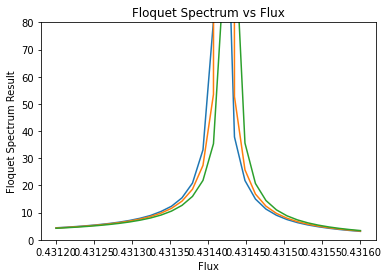

In [18]:
# Plotting
plt.plot(flux_values, floquet_results11)
plt.plot(flux_values, floquet_results21)
plt.plot(flux_values, floquet_results31)
# plt.plot(flux_values, -(floquet_results/2/np.pi)[:,4]+(floquet_results/2/np.pi)[:,7])
plt.xlabel('Flux')
plt.ylabel('Floquet Spectrum Result')
plt.title('Floquet Spectrum vs Flux')
# plt.ylim(7.004,7.0045)
plt.ylim(0,80)
plt.show()